In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib nbagg
from Object_detection_features import *
import gym
from gym import wrappers

% matplotlib inline

In [2]:
env = gym.make('Skiing-v0')
# Самая долгая часть. Считается один раз. В конструкторе находятся все классы объектов и фон
odf = ObjectDetectionFeatures(env)

INFO:gym.envs.registration:Making new env: Skiing-v0
[2017-01-21 17:28:24,482] Making new env: Skiing-v0


In [3]:
# Генерим картинку
image = env.ale.getScreenGrayscale()
# Создаем новый вектор признаков
new_features = odf.get_distance_features(image)

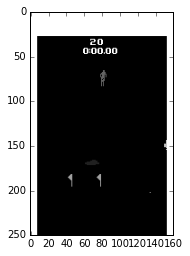

In [4]:
plt.imshow(image[:,:,0], cmap='Greys')

In [5]:
# на i-й позиции списка cl находится яркость пикселя, характерного для i-го класса
cl = list(odf.all_classes)

In [6]:
# Признаки построены следующем образом:
# Для каждой пары классов находятся 2 ближайших объекта (по центрам масс). 
# Далее для каждой такой пары считаются проекции расстояний на x и на y. 
# В первой позиции стоит проекция на х расстояния между ближайшими объектами из нулевого и первого класса и так далее  
new_features

array([  12.0021645 ,  -95.49494949,  -69.57983193,  -75.26143791,
          3.71428571, -113.18888889,  -82.28787879,   14.93939394,
         -8.28787879,  -17.69393939,   74.        ,  -32.63333333])

In [7]:
# на i-й позиции списка cl находится яркость пикселя, характерного для i-го класса
cl = list(odf.all_classes)

In [8]:
# Признаки построены следующем образом:
# Для каждой пары классов находятся 2 ближайших объекта (по центрам масс). 
# Далее для каждой такой пары считаются проекции расстояний на x и на y. 
# В первой позиции стоит проекция на х расстояния между ближайшими объектами из нулевого и первого класса и так далее  
new_features

array([  12.0021645 ,  -95.49494949,  -69.57983193,  -75.26143791,
          3.71428571, -113.18888889,  -82.28787879,   14.93939394,
         -8.28787879,  -17.69393939,   74.        ,  -32.63333333])

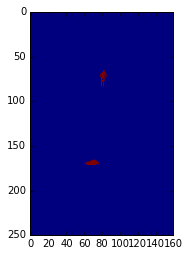

In [9]:
plt.imshow((image[:, :, 0] == cl[0]) | (image[:, :, 0] == cl[1]))
plt.show()

In [11]:
# Генерим картинку
image = env.ale.getScreenGrayscale()
# Делаем упрощение
new_im = odf.get_simple_image(image[:, :, 0])

/Users/IzmailovPavel/Documents/Education/Programming/Machine Learning/rl/deephack/Object_detection_features.py:211: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  new_image[x_low - 1:x_top + 1, y_left - 1:y_right + 1] = color


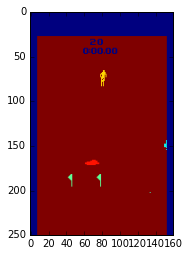

In [12]:
plt.imshow(image[:, :, 0])
plt.show()

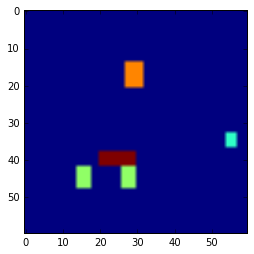

In [13]:
plt.imshow(new_im)
plt.show()

In [18]:
from skimage.transform import resize
from skimage.color import rgb2gray

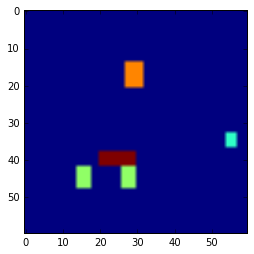

In [16]:
plt.imshow(new_im)
plt.show()

In [17]:
import warnings
warnings.filterwarnings('ignore')

In [26]:
max_observations = 20000
observations = []
render = False
count = 0

env_name = 'Skiing-v0'
env = gym.make(env_name)

while True:
    if len(observations) >= max_observations: break
    s = env.reset()
    if count % 10 == 0:
        observation = env.ale.getScreenGrayscale()
        observations.append(odf.get_simple_image(rgb2gray(observation[:, :, 0])))
    count += 1
    done = False

    while not done:
        if render: env.render()
        if len(observations) >= max_observations: break
        a = env.action_space.sample()
        s, r, done, _ = env.step(a)
        if count % 10 == 0:
            observation = env.ale.getScreenGrayscale()
            observations.append(odf.get_simple_image(rgb2gray(observation[:, :, 0])))
            if not len(observations) % 1000:
                print(len(observations))
        a = env.action_space.sample()
        count += 1
        
env.close()

INFO:gym.envs.registration:Making new env: Skiing-v0
[2017-01-21 06:53:24,740] Making new env: Skiing-v0


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000


/Users/IzmailovPavel/Documents/Education/Programming/Machine Learning/rl/deephack/Object_detection_features.py:211: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  new_image[x_low - 1:x_top + 1, y_left - 1:y_right + 1] = color


In [28]:
observations = np.array(observations)

In [29]:
np.save('observations_simple_20k.npy', observations)

In [6]:
observations = np.load('observations_simple_20k.npy')

In [7]:
observations.shape

(20000, 60, 60)

In [8]:
observations = observations.reshape(20000, 1, 60, 60)

In [9]:
from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, UpSampling2D, Reshape, Flatten
from keras.models import Model
border_mode = 'same'

input_img = Input(shape=observations.shape[1:])

x = Convolution2D(16, 8, 8, activation='relu', border_mode=border_mode)(input_img)
x = MaxPooling2D((2, 2), border_mode=border_mode)(x)
x = Convolution2D(32, 4, 4, activation='relu', border_mode=border_mode)(x)
x = MaxPooling2D((2, 2), border_mode=border_mode)(x)
filters_shape = x.get_shape()
flattened = Flatten()(x)
flat_shape = flattened.get_shape()
encoded = Dense(64, activation='relu')(flattened)

x = Dense(int(flat_shape[1]), activation='relu')(encoded)
x = Reshape(tuple([int(shp) for shp in filters_shape[1:]]))(x)
x = Convolution2D(32, 4, 4, activation='relu', border_mode=border_mode)(x)
x = UpSampling2D((2, 2))(x)
x = Convolution2D(16, 8, 8, activation='relu', border_mode=border_mode)(x)
x = UpSampling2D((2, 2))(x)
x = Convolution2D(1, 3, 3, activation='relu', border_mode=border_mode)(x)

decoded = x

encoder = Model(input_img, encoded)
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='mse')

Using TensorFlow backend.


In [10]:
autoencoder.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 1, 60, 60)     0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 16, 60, 60)    1040        input_1[0][0]                    
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 16, 30, 30)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 32, 30, 30)    8224        maxpooling2d_1[0][0]             
___________________________________________________________________________________________

In [11]:
import keras
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(float(logs.get('loss')))
    
    def on_epoch_end(self, epoch, logs={}):
        self.val_losses.append(logs.get('val_loss'))


In [12]:
history = LossHistory()
autoencoder.fit(observations, observations,
                nb_epoch=40,
                batch_size=32,
                shuffle=True,
                callbacks=[history])

Epoch 1/40
20000/20000 [==============================] - 310s - loss: 466.0637   
Epoch 2/40
20000/20000 [==============================] - 346s - loss: 177.0336   
Epoch 3/40
20000/20000 [==============================] - 350s - loss: 132.9763   
Epoch 4/40
20000/20000 [==============================] - 356s - loss: 111.7421   
Epoch 5/40
20000/20000 [==============================] - 359s - loss: 96.2776   
Epoch 6/40
20000/20000 [==============================] - 356s - loss: 84.9050   
Epoch 7/40
20000/20000 [==============================] - 354s - loss: 77.5212   
Epoch 8/40
20000/20000 [==============================] - 357s - loss: 70.2496   
Epoch 9/40
20000/20000 [==============================] - 357s - loss: 66.2044   
Epoch 10/40
20000/20000 [==============================] - 361s - loss: 58.1283   
Epoch 11/40
20000/20000 [==============================] - 363s - loss: 54.8720   
Epoch 12/40
20000/20000 [==============================] - 363s - loss: 52.6134   
Epoch 13/

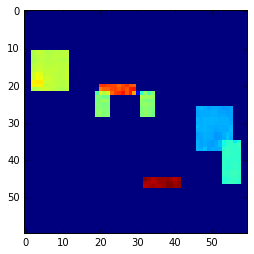

In [25]:
plt.imshow(autoencoder.predict(np.array([observations[25]]))[0, 0], interpolation='Nearest')

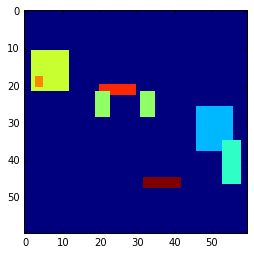

In [26]:
plt.imshow(observations[25][0], interpolation='Nearest')

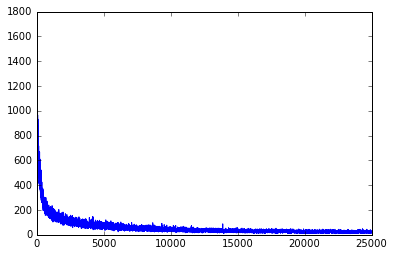

In [29]:
plt.plot(history.losses)
plt.show()

In [27]:
autoencoder.save_weights('./data/Autoencoder_21_01.h5')
autoencoder.to_json()
import json
with open('./data/Autoencoder_21_01.txt', 'w') as outfile:
    json.dump(autoencoder.to_json(), outfile)

In [28]:
encoder.save_weights('./data/Encoder_21_01.h5')
autoencoder.to_json()
import json
with open('./data/Encoder_21_01.txt', 'w') as outfile:
    json.dump(encoder.to_json(), outfile)

In [ ]:
sample_features = encoder.predict(observations)
np.savez('./data/sample_features_20k.npz', sample_features)

## Check overfit

In [13]:
from keras.models import model_from_json
import json

with open('./data/Autoencoder_21_01.txt', 'r') as model_file:
     model = model_from_json(json.loads(next(model_file)))
        
model.load_weights('./data/Autoencoder_21_01.h5')

In [19]:
max_observations = 1000
test_observations = []
render = False
count = 0

env_name = 'Skiing-v0'
env = gym.make(env_name)

while True:
    if len(test_observations) >= max_observations: break
    s = env.reset()
    if count % 10 == 0:
        observation = env.ale.getScreenGrayscale()
        test_observations.append(odf.get_simple_image(rgb2gray(observation[:, :, 0])))
    count += 1
    done = False

    while not done:
        if render: env.render()
        if len(test_observations) >= max_observations: break
        a = env.action_space.sample()
        s, r, done, _ = env.step(a)
        if count % 10 == 0:
            observation = env.ale.getScreenGrayscale()
            test_observations.append(odf.get_simple_image(rgb2gray(observation[:, :, 0])))
            if not len(test_observations) % 100:
                print(len(test_observations))
        a = env.action_space.sample()
        count += 1
        
env.close()

INFO:gym.envs.registration:Making new env: Skiing-v0
[2017-01-21 17:39:47,955] Making new env: Skiing-v0


100
200
300
400
500
600
700
800
900
1000


/Users/IzmailovPavel/Documents/Education/Programming/Machine Learning/rl/deephack/Object_detection_features.py:211: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  new_image[x_low - 1:x_top + 1, y_left - 1:y_right + 1] = color


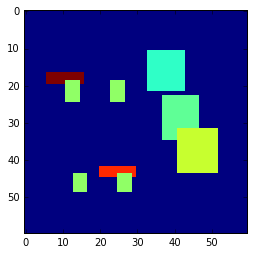

In [21]:
plt.imshow(test_observations[100], interpolation='Nearest')

In [22]:
test_observations = np.array(test_observations)

In [23]:
test_observations = test_observations.reshape(1000, 1, 60, 60)

In [26]:
predicted = model.predict(test_observations)

In [28]:
np.linalg.norm(predicted - test_observations)**2 / test_observations.size

33.052939185961904

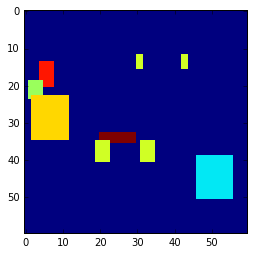

In [29]:
plt.imshow(test_observations[25][0], interpolation='Nearest')

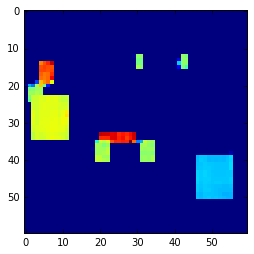

In [31]:
plt.imshow(model.predict(np.array([test_observations[25]]))[0, 0], interpolation='Nearest')